In [71]:
import requests
from urllib.request import urlopen
from urllib.parse import urlencode,unquote,quote_plus
import urllib
import lxml
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import time
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns

In [236]:
info2_df = pd.read_csv("train.csv")
info2_df

,Unnamed: 0,title,주문,이유
0,0,"수원지방법원 2018. 8. 10 선고 2015가단119624(본소), 2015가단...",주문\n1. 2015. 2. 15. 00:04경 수원시 영통구 C건물 부근에서 D ...,이유1. 기초사실가. F는 2015. 2. 15. 00:04경 수원시 영통구 C건물...
1,1,"울산지방법원 2014. 8. 27 선고 2013나7264,2013나7271(병합) ...",주 문\n1. 제1심 판결을 다음과 같이 변경한다.\n가. 피고 E는 원고 A에게 ...,이 유1. 기초사실가. F는 2012. 8. 10. 01:45경 아반떼 승용차(이하...
2,2,"수원지방법원 2009. 1. 7 선고 2007가단27335, 46510(병합) 판결...","주문\n1. 피고 ▶◇◇◇◇◇◇◇ 주식회사는 원고에게 86,809,964원과 이에 ...",이유1. 손해배상책임의 발생\n가. 책임의 근거\n(1) 인정사실\n(가) 피고 ♠...
3,3,"서울지방법원 1997. 6. 10 선고 95가단24645, 95661(병합) 판결 ...","주 문 1. 피고는 원고 송◎자에게 금 115,191,716원, 원고 김×정, 김유...","이 유1. 손해배상책임의 발생가. 책임의 근거\n다음 사실은 갑제1 내지 3호증, ..."
4,4,"광주지방법원 1996. 12. 13 선고 96나2732 판결 [손해배상(자),손해배...",【주 문】\n1. 원고의 당심에서의 청구취지 확장에 따라 원심판결을 제2항과 같이 ...,【이 유】1. 손해배상책임의 발생\n당원이 이 부분에 관하여 설시할 판결이유는 원심...
...,...,...,...,...
7881,7881,서울중앙지방법원 2009. 8. 20 선고 2009가합13236 판결 [부당이득금 ...,[주문]\n1. 원고의 피고들에 대한 주위적 청구 및 예비적 청구를 모두 기각한다....,[이유]1. 주위적 청구가. ○○계약 채무불이행책임 청구(1) 청구원인(가) 원고는...
7882,7882,서울중앙지방법원 2009. 7. 17 선고 2008가합110406 판결 [손해배상(...,[주 문]\n1. 원고의 피고 ♥◈◈◈ 주식회사에 대한 소를 각하한다.\n2. 피고...,[이 유]1. 기초사실가. 당사자의 지위\n\n원고는 서울 송파구 oo동 __ 소재...
7883,7883,서울중앙지방법원 2009. 7. 17 선고 2008가합85654 판결 [손해배상(기...,주 문\n1. 원고의 청구를 모두 기각한다.\n2. 소송비용은 원고가 부담한다.,이 유1. 기초사실가. 피고는 ‘◈◈◈◈◈’라는 브랜드의 대한민국 내 판매권을 가지...
7884,7884,서울중앙지방법원 2009. 6. 18 선고 2007가합82740 판결 [손해배상(기...,주 문\n1. 피고는 별지 기재 프로그램을 사용하여서는 아니된다.\n2. 피고는 보...,"이 유1. 기초사실\n【증거】갑1, 2, 7, 내지 14, 19, 21의1ㆍ2, 2..."


In [2]:
판례목록_df = pd.read_html("법령검색목록.html")
판례목록_df = 판례목록_df[0]
# # 판례목록_df = 판례목록_df[(판례목록_df["판결유형"] == "민사") | (판례목록_df["판결유형"] == "일반행정") | (판례목록_df["판결유형"] == "가사") | (판례목록_df["판결유형"] == "세무")]
판례목록_df = 판례목록_df[(판례목록_df["판결유형"] == "민사")]
# for i in 판례목록_df["판례ID"]:
#     print("https://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID={}&type=HTML".format(i))
set(판례목록_df["제목"])
    

{nan,
 '탈퇴무효확인',
 '토지소유권이전청구소송',
 '토지차임',
 '임차보증금반환·건물인도',
 '징계면직무효확인등',
 '부동산소유권확인',
 '압류및전부명령',
 '표장사용중지가처분',
 '주식양도무효',
 '임대료',
 '유체동산가압류이의',
 '방해배제등',
 '건물명도,건물철거등',
 '주식매수선택권부여결의등부존재확인',
 '개발비등',
 '소유권말소등기·소유권말소등기',
 '지분권이전등기',
 '주민총회결의 무효확인',
 '연대채무부존재확인',
 '담장철거등·소유권이전등기',
 '부당이득·부당이득금',
 '징계면직처분취소',
 '노동조합설립무효확인',
 '주차장관리·운영권확인청구의소',
 '부당이득금반환·부당이득금·부당이득금',
 '의장등록명의자말소',
 '채무부존재등',
 '등기관처분이의',
 '면허명의변경등',
 '대지권이전등기등',
 '손해배상(기)·공사대금',
 '교섭대표노동조합지위확인',
 '연월차수당지급',
 '지료·지료',
 '임대료등',
 '계파부존재확인',
 '구상금등·부당이득금반환',
 '협정무효확인',
 '정리채권에대한부인의소',
 '건물철거등·주위토지통행권확인',
 '소유권이전등기말소,손해배상',
 '소유권이전등기·가등기말소',
 '은익재산확인등',
 '전부결정,채권압류',
 '선박우선채권부존재확인',
 '해고 무효확인',
 '엘피지집단공급시설소유권확인·가스공급시설의철거청구',
 '명의신탁해지로인한소유권이전등기',
 '건물철거,건물매매대금등',
 '공유지분이전등기말소·소유권이전등기말소',
 '종업원지위확인·종업원지위',
 '경정',
 '명의변경',
 '이익배당금',
 '관리단집회회장등직무집행정지가처분',
 '소유권이전등기및근저당권일부말소',
 '업무방해금지가처분',
 '건물명도등·소유권이전등기',
 '전기간선시설설치비반환·공사비',
 '건물명도,소유권확인등',
 '특허출원인명의변경·손해배상(지)',
 '예치금 반환',
 '소유권이전등기말소',
 '신탁재산반환·공탁금출급청구권확인',
 '반론보도심판청구',
 '손해배상(

In [3]:
판례목록_하등_df = pd.read_html("법령검색목록(1).html")
판례목록_하등_df = 판례목록_하등_df[0]
name_list = [str(i) for i in 판례목록_하등_df["제목"] if "손해배상" in str(i)]
name_list = list(set(name_list))
손해배상_하등_df = 판례목록_하등_df[판례목록_하등_df["제목"] == name_list[0]]
손해배상_하등_df
for idx,i in enumerate(name_list):
    if idx==0:
        continue
    손해배상_하등_df = 손해배상_하등_df.append((판례목록_하등_df[판례목록_하등_df["제목"] == i]),ignore_index=True)
손해배상_하등_df

,순번,판례ID,제목,법원,사건유형,판결유형,선고일자
0,450,146042,손해배상(자)청구사건,광주고법,하급심,민사,1994.04.01
1,2146,77021,손해배상(자)청구사건,대구고법,하급심,민사,1987.11.10
2,2168,76919,손해배상(자)청구사건,대구고법,하급심,민사,1987.07.07
3,2170,76837,손해배상(자)청구사건,대구고법,하급심,민사,1987.06.30
4,2171,76831,손해배상(자)청구사건,대구고법,하급심,민사,1987.06.09
...,...,...,...,...,...,...,...
2895,6538,119382,손해배상(지)청구사건,부산지법,하급심,민사,1992.07.07
2896,7212,210615,영업비밀침해금지및손해배상등,서울고등법원,하급심,민사,2017.07.06
2897,15414,140320,손해배상(기)·정정보도등,서울남부지법,하급심,민사,2009.09.29
2898,1490,179407,손해배상(이혼),대구가정법원,하급심,가사,2013.05.23


In [28]:
# 판례목록_하등_df
# # 판례_하등 XML 상세조회
# info_하등 = []
# def crawling_func(url):
#     global info
#     text_판시사항 = ""
#     text_판결요지 = ""
#     text_참조조문 = ""
#     text_참조판례 = ""
#     text_주문 = ""
#     text_청구취지 = ""
#     try:
#         response = requests.get(url)
#         response.raise_for_status()
#         soup = BeautifulSoup(response.content, 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)
#         판시사항_soup = BeautifulSoup(soup.판시사항.get_text(),'lxml')
# #         info.append(판시사항_soup.get_text())
#         text_판시사항+=판시사항_soup.get_text()
#         판결요지_soup = BeautifulSoup(soup.판결요지.get_text(),'lxml')
# #         info.append(판결요지_soup.get_text())
#         text_판결요지+=판결요지_soup.get_text()
#         참조조문_soup = BeautifulSoup(soup.참조조문.get_text(),'lxml')
#         for i in 참조조문_soup:
#             try:
#                 text_참조조문+=i.get_text()
#             except:
#                 pass
#         참조판례_soup = BeautifulSoup(soup.참조판례.get_text(),'lxml')
#         text_참조판례+=참조판례_soup.get_text()
        
#         # 주문 crawling
#         response = requests.get(url2)
#         response.raise_for_status()
#         soup = BeautifulSoup(response.content, 'lxml-xml')
#         try:
#             i_list = soup.find("div",attrs={"class":"pgroup","id":"conScroll"}).find_all("p",attrs={"class":"pty4_dep1"})
#             for i in i_list:
#                 if i.next_sibling.next_sibling.get_text()[1:-1]=="주 문":
#                     text_주문+=i.next_sibling.next_sibling.next_sibling.next_sibling.get_text()
#                     break
#         except:
#             pass
#         try:
#             i_list = soup.find("div",attrs={"class":"pgroup","id":"conScroll"}).find_all("p",attrs={"class":"pty4_dep1"})
#             for i in i_list:
#                 if i.next_sibling.next_sibling.get_text()[1:-1]=="청구취지 및 항소취지" or i.next_sibling.next_sibling.get_text()[1:-1]=="청구취지":
#                     text_청구취지 += i.next_sibling.next_sibling.next_sibling.next_sibling.get_text()
#                     break
#         except:
#             pass
#         info_하등.append([ID,text_판시사항,text_판결요지,text_참조조문,text_참조판례,text_주문,text_청구취지])
# #         print(info_하등)
#     except:
#         print(url,"오류발생, 재귀호출 시작")
#         time.sleep(1)
#         crawling_func(url)
#     finally:
#         return

# for idx,ID in enumerate(손해배상_하등_df["판례ID"]):   
#     #기본 url
#     url = "http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID={}&type=XML".format(ID)
#     url2 = "https://www.law.go.kr/precInfoP.do?mode=0&precSeq={}&vSct=*".format(ID)
#     crawling_func(url)
#     print(idx,ID)

# # info_하등


0 165171
1 205564
2 188432
3 183167
4 205510
5 167374
6 158528
7 74874
8 74855
9 75007
10 71848
11 71846
12 78213
13 120823
14 158558
15 120176
16 133481
17 173372
18 173340
19 71164
20 192385
21 118780
22 172804
23 70572
24 126030
25 172135
26 172145
27 126026
28 118303
29 69820
30 119193
31 118253
32 118538
33 119274
34 119294
35 119276
36 118460
37 184658
38 205496
39 65017
40 172253
41 118611
42 118444
43 152088
44 152186
45 78445
46 172872
47 172860
48 118853
49 118686
50 217159
51 217051
52 69915
53 71871
54 206171
55 212425
56 208477
57 159788
58 138226
59 207164
60 176127
61 176233
62 76752
63 140320
64 176231
65 142947
66 69740
67 69676
68 205652
69 177819
70 72156
71 146042
72 77021
73 76919
74 76837
75 76831
76 76760
77 76756
78 146045
79 77025
80 77024
81 76834
82 76833
83 76827
84 76826
85 76822
86 146013
87 76879
88 76859
89 76778
90 76678
91 118851
92 146034
93 76954
94 140689
95 182695
96 198557
97 198552
98 73539
99 75804
100 120531
101 163296
102 163284
103 214537
104

822 71946
823 71944
824 71945
825 71942
826 71932
827 71906
828 71901
829 71898
830 71868
831 71805
832 119039
833 76882
834 76874
835 76873
836 76769
837 76251
838 76170
839 76147
840 76154
841 75974
842 75956
843 75747
844 75743
845 75738
846 75729
847 75726
848 75668
849 75665
850 75659
851 75658
852 75656
853 75653
854 75651
855 75646
856 75647
857 75643
858 76941
859 76881
860 76336
861 76259
862 76257
863 76166
864 75762
865 75633
866 75623
867 76338
868 76169
869 118694
870 76847
871 76782
872 76672
873 76604
874 76600
875 76431
876 76340
877 76254
878 76253
879 76249
880 76158
881 76072
882 76070
883 75862
884 75648
885 75649
886 75631
887 75625
888 75961
889 75770
890 75735
891 76867
892 76763
893 75976
894 75858
895 76157
896 76964
897 76950
898 74515
899 73962
900 76222
901 75206
902 75188
903 74963
904 74463
905 74070
906 73487
907 72945
908 75748
909 76820
910 76643
911 75929
912 75532
913 190181
914 75356
915 75178
916 75144
917 75136
918 75123
919 74849
920 74980
921 771

1541 143194
1542 128273
1543 146404
1544 78888
1545 127665
1546 78338
1547 144629
1548 64619
1549 65164
1550 128308
1551 77776
1552 78801
1553 78768
1554 78824
1555 77330
1556 77833
1557 65161
1558 217189
1559 185860
1560 175114
1561 216049
1562 70831
1563 70733
1564 70418
1565 70010
1566 69714
1567 69533
1568 69507
1569 212161
1570 71646
1571 192845
1572 71524
1573 71455
1574 71372
1575 148972
1576 118541
1577 176404
1578 162993
1579 145447
1580 149314
1581 159821
1582 142013
1583 140693
1584 143160
1585 78241
1586 144157
1587 194909
1588 185853
1589 184316
1590 191003
1591 164097
1592 157560
1593 149312
1594 148864
1595 125213
1596 125208
1597 124920
1598 125074
1599 64822
1600 71051
1601 71010
1602 70966
1603 70887
1604 70764
1605 70707
1606 70538
1607 70510
1608 70449
1609 70351
1610 145685
1611 69541
1612 212325
1613 120969
1614 120590
1615 129739
1616 120464
1617 129660
1618 129672
1619 120155
1620 120070
1621 119367
1622 119366
1623 119203
1624 119031
1625 118535
1626 118471
162

2238 138227
2239 136181
2240 210073
2241 127759
2242 125217
2243 125216
2244 125206
2245 125185
2246 125184
2247 70991
2248 70983
2249 70915
2250 70860
2251 70858
2252 70791
2253 70770
2254 139803
2255 70683
2256 70662
2257 210007
2258 70638
2259 70632
2260 70628
2261 70598
2262 70594
2263 70571
2264 70564
2265 70507
2266 70486
2267 70485
2268 70481
2269 70458
2270 70454
2271 70427
2272 70420
2273 70419
2274 70394
2275 70392
2276 70360
2277 168201
2278 70284
2279 70248
2280 70199
2281 70195
2282 70191
2283 70138
2284 70114
2285 210187
2286 210211
2287 69875
2288 69870
2289 69869
2290 69845
2291 69789
2292 69710
2293 69685
2294 77561
2295 77597
2296 77278
2297 77361
2298 77596
2299 77518
2300 78026
2301 78536
2302 69666
2303 69642
2304 69641
2305 69629
2306 69625
2307 69604
2308 69574
2309 69546
2310 69542
2311 69537
2312 212377
2313 212401
2314 212411
2315 212445
2316 71649
2317 71638
2318 71623
2319 71622
2320 192840
2321 71607
2322 71356
2323 71369
2324 71383
2325 212219
2326 212255


In [29]:
# info_하등법령_df = pd.DataFrame(info_하등,columns = ["ID","판시사항","판결요지","참조조문","참조판례","주문","청구취지"])
# # info_하등법령_df["판결유형"] = 판례목록_하등_df["ID"]
# info_하등법령_df

,ID,판시사항,판결요지,참조조문,참조판례,주문,청구취지
0,165171,甲이 배우자 乙의 성기능 장애로 인하여 사실혼관계가 단기간에 파탄되었다는 이유로 乙...,甲이 배우자 乙의 성기능 장애로 인하여 사실혼관계가 단기간에 파탄되었다는 이유로 乙...,민법 제806조,,"1. 피고(반소원고) 1은 원고(반소피고)에게, 가. 20,000,000원과 ...","1. 본소 가. 주위적 청구취지피고(반소원고, 이하 ‘피고’라 한다)들은 연대하여..."
1,205564,,,,,1. 제1심 판결을 다음과 같이 변경한다. 가. 2011. 6. 2. 12:3...,1. 청구취지 가. 본소 2011. 6. 2. 12:30경 남원시 (주소 생략)...
2,188432,,,,,1. 본소에 관한 피고(반소원고)의 항소를 기각한다. 2. 당심에서 제기된...,"1. 청구취지 가. 본소 원고(반소피고, 이하 ‘원고’라고만 한다)가 피고(반소원..."
3,183167,,,,,1. 제1심 판결 중 반소에 관하여 아래에서 지급을 명하는 돈을 초과하는 원고(반...,"1. 청구취지 본소: 원고(반소피고, 이하 ‘원고’라고 한다)와 피고(반소원고, ..."
4,205510,,,,,"1. 원고(반소피고)는 피고(반소원고)에게 47,177,726원과 이에 대하여...",1. 본소 : 2011. 6. 2. 12:30경 남원시 (주소 생략) 소재 원고 ...
...,...,...,...,...,...,...,...
2895,166435,[1] 배당이의의 소에 따른 재배당절차에서 집행법원이 일시적으로 배당금을 보관하여야...,"[1] 배당이의의 소에 따른 재배당절차는 어디까지나 집행법원의 소관 업무이고, 재배...",[1] \n \n \n 민사집행법 제154조 ...,,1. 제1심판결 중 피고 패소 부분을 취소한다. 2. 위 취소 부분에 대한 원...,"1. 청구취지 피고는 원고에게 50,000,000원 및 이에 대한 이 사건 소장부본..."
2896,163584,미스코리아 선발대회를 개최하는 甲 신문사가 미스월드(Miss World) 측과 체결...,미스코리아 선발대회를 개최하는 甲 신문사가 세계 미인대회 중 하나인 미스월드(Mis...,민법 제105조,,1. 원고의 피고들에 대한 청구를 모두 기각한다. 2. 소송비용은 원고가 부담한다.,피고들은 [별지] 목록 기재와 같은 행위를 하여서는 아니 된다. 피고들은 연대하여 ...
2897,217121,,,,,1. 제1심 판결 중 피고 패소 부분을 취소하고 그 부분에 해당하는 원고들과 원...,청구취지 1. 소유권에 기한 침해금지청구 피고는 원고들과 원고승계참가인들(이하 ‘...
2898,214521,"甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating...","甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating...","민법 제105조, 제389조 제2항",,1. 원고들의 이 사건 소 중 [별지 1] 목록 기재 소송의 취하절차 이행청구 ...,1. 가. 피고는 원고들에게 [별지 1] 목록 기재 각 사건에 관하여 취하절차를 각...


In [96]:
# info_하등법령_df["판시사항"].replace("",np.nan,inplace=True)
# info_df = info_하등법령_df.drop(info_하등법령_df[info_하등법령_df["판시사항"].isna()].index)
# info_df["판시+주문"] = info_df["판시사항"]+info_df["참조조문"]
# info_df

In [169]:
# info_df.to_excel("손해배상.xlsx",index=False)

In [237]:
info_df = pd.read_excel("손해배상.xlsx")
info_df

,ID,판시사항,판결요지,참조조문,참조판례,주문,청구취지,판시+주문
0,165171,甲이 배우자 乙의 성기능 장애로 인하여 사실혼관계가 단기간에 파탄되었다는 이유로 乙...,甲이 배우자 乙의 성기능 장애로 인하여 사실혼관계가 단기간에 파탄되었다는 이유로 乙...,민법 제806조,NaN,"1. 피고(반소원고) 1은 원고(반소피고)에게, 가. 20,000,000원과 ...","1. 본소 가. 주위적 청구취지피고(반소원고, 이하 ‘피고’라 한다)들은 연대하여...",甲이 배우자 乙의 성기능 장애로 인하여 사실혼관계가 단기간에 파탄되었다는 이유로 乙...
1,167374,"甲 주식회사의 전기재료사업부 연구개발팀에서 황산니켈, 황산코발트, 황산망간 등의 물...","甲 주식회사의 전기재료사업부 연구개발팀에서 황산니켈, 황산코발트, 황산망간 등의 물...","민법 제396조, \n 제750조, \n 제751조, \n...",NaN,1. 2010. 9. 26.경 소외 1의 사망과 관련하여 원고(반소피고)의 피고...,"본소: 2010. 9. 26.경 소외 1의 사망과 관련하여 원고(반소피고, 이하 ‘...","甲 주식회사의 전기재료사업부 연구개발팀에서 황산니켈, 황산코발트, 황산망간 등의 물..."
2,74874,증인의 허위진술과 재심사유,원심에서의 증인의 진술이 허위로 밝혀져 그것이 유죄로 확정되었다 할지라도 재심대상 ...,"민사소송법 제422조 제1항 제7호, \n 제2항","1960. 8. 18. 선고, 4292민상879 판결(판례카아드 6943호, 판결요...",재심의 소를 각하한다.재심 소송비용은 재심원고(본소 피고)의 부담으로 한다.,NaN,"증인의 허위진술과 재심사유민사소송법 제422조 제1항 제7호, \n 제2항"
3,74855,민사소송법 제422조 제1항 제10호 소정의 “전에 선고한 확정판결”의 뜻\n ...,"민사소송법 제422조 제1항 제10호 소정의 소위 전에 선고한 확정판결이라는 것은,...",민사소송법 제422조 제1항 제10호,NaN,소를 각하한다.소송비용은 원고(재심원고)의 부담으로 한다.,"대구고등법원 1976. 3. 19. 선고, 75나916 판결을 취소한다.피고(재심피...",민사소송법 제422조 제1항 제10호 소정의 “전에 선고한 확정판결”의 뜻\n ...
4,75007,증인의 허위진술이 판결의 증거가 된 때의 의미,민사소송법 제422조 제1항 제7호 소정의 재심사유로서 증인의 허위진술이 판결의 증...,민사소송법 제422조,1977.7.12. 선고 77다484 판결(판결요지집 민사소송법 제422조 (104...,항소를 기각한다. 소송 총비용은 원고들의 부담으로 한다.,NaN,증인의 허위진술이 판결의 증거가 된 때의 의미민사소송법 제422조
...,...,...,...,...,...,...,...,...
1966,138567,[1] 횡단보도가 설치되어 있지 않고 차량 통행이 빈번하지 아니한 농촌 또는 교외의...,"[1] 자동차 전용도로나 왕복 4차로 이상의 도로, 중앙분리대가 설치된 도로 또는 ...","[1] \n 민법 제750조, \n 도로교통법 제27조, ...",NaN,"1. 피고(반소원고)는 원고(반소피고)들에게 각 21,428,303원과 이에 대...","본소 : 피고(반소원고, 이하 ‘피고’라 한다)는 원고(반소피고, 이하 ‘원고’라 ...",[1] 횡단보도가 설치되어 있지 않고 차량 통행이 빈번하지 아니한 농촌 또는 교외의...
1967,118967,"가. 우리나라에서 수리, 개조작업중이던 외국선박의 충돌사고로 인한 별도의 민사소송 ...",가. 각종 선박의 수리 및 개조 등을 사업목적으로 하는 우리나라의 갑 법인에 의하여...,"가.\n\n 민사소송법 제16조 \n, 나.\n 중재법 제...",NaN,1. 원고들은 피고에 대하여 별지기재의 선박충돌사고로 인하여 발생한 손해에 관...,주문과 같다.,"가. 우리나라에서 수리, 개조작업중이던 외국선박의 충돌사고로 인한 별도의 민사소송 ..."
1968,166435,[1] 배당이의의 소에 따른 재배당절차에서 집행법원이 일시적으로 배당금을 보관하여야...,"[1] 배당이의의 소에 따른 재배당절차는 어디까지나 집행법원의 소관 업무이고, 재배...",[1] \n \n \n 민사집행법 제154조 ...,NaN,1. 제1심판결 중 피고 패소 부분을 취소한다. 2. 위 취소 부분에 대한 원...,"1. 청구취지 피고는 원고에게 50,000,000원 및 이에 대한 이 사건 소장부본...",[1] 배당이의의 소에 따른 재배당절차에서 집행법원이 일시적으로 배당금을 보관하여야...
1969,163584,미스코리아 선발대회를 개최하는 甲 신문사가 미스월드(Miss World) 측과 체결...,미스코리아 선발대회를 개최하는 甲 신문사가 세계 미인대회 중 하나인 미스월드(Mis...,민법 제105조,NaN,1. 원고의 피고들에 대한 청구를 모두 기각한다. 2. 소송비용은 원고가 부담한다.,피고들은 [별지] 목록 기재와 같은 행위를 하여서는 아니 된다. 피고들은 연대하여 ...,미스코리아 선발대회를 개최하는 甲 신문사가 미스월드(Miss World) 측과 체결...


In [231]:
real_info_df = pd.DataFrame()
real_info_df = info_df[["ID","참조조문","주문"]]
real_info_df["이유"] = info_df["판시사항"].map(str) + " " + info_df["판결요지"].map(str) + " " + info_df["주문"]
real_info_df = real_info_df.drop(real_info_df[real_info_df["이유"].isna()].index)
info_df = real_info_df
info_df

<ipython-input-231-c533864be65a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_info_df["이유"] = info_df["판시사항"].map(str) + " " + info_df["판결요지"].map(str) + " " + info_df["주문"]


,ID,참조조문,주문,이유
0,165171,민법 제806조,"1. 피고(반소원고) 1은 원고(반소피고)에게, 가. 20,000,000원과 ...",甲이 배우자 乙의 성기능 장애로 인하여 사실혼관계가 단기간에 파탄되었다는 이유로 乙...
1,167374,"민법 제396조, \n 제750조, \n 제751조, \n...",1. 2010. 9. 26.경 소외 1의 사망과 관련하여 원고(반소피고)의 피고...,"甲 주식회사의 전기재료사업부 연구개발팀에서 황산니켈, 황산코발트, 황산망간 등의 물..."
2,74874,"민사소송법 제422조 제1항 제7호, \n 제2항",재심의 소를 각하한다.재심 소송비용은 재심원고(본소 피고)의 부담으로 한다.,증인의 허위진술과 재심사유 원심에서의 증인의 진술이 허위로 밝혀져 그것이 유죄로 확...
3,74855,민사소송법 제422조 제1항 제10호,소를 각하한다.소송비용은 원고(재심원고)의 부담으로 한다.,민사소송법 제422조 제1항 제10호 소정의 “전에 선고한 확정판결”의 뜻\n ...
4,75007,민사소송법 제422조,항소를 기각한다. 소송 총비용은 원고들의 부담으로 한다.,증인의 허위진술이 판결의 증거가 된 때의 의미 민사소송법 제422조 제1항 제7호 ...
...,...,...,...,...
1966,138567,"[1] \n 민법 제750조, \n 도로교통법 제27조, ...","1. 피고(반소원고)는 원고(반소피고)들에게 각 21,428,303원과 이에 대...",[1] 횡단보도가 설치되어 있지 않고 차량 통행이 빈번하지 아니한 농촌 또는 교외의...
1967,118967,"가.\n\n 민사소송법 제16조 \n, 나.\n 중재법 제...",1. 원고들은 피고에 대하여 별지기재의 선박충돌사고로 인하여 발생한 손해에 관...,"가. 우리나라에서 수리, 개조작업중이던 외국선박의 충돌사고로 인한 별도의 민사소송 ..."
1968,166435,[1] \n \n \n 민사집행법 제154조 ...,1. 제1심판결 중 피고 패소 부분을 취소한다. 2. 위 취소 부분에 대한 원...,[1] 배당이의의 소에 따른 재배당절차에서 집행법원이 일시적으로 배당금을 보관하여야...
1969,163584,민법 제105조,1. 원고의 피고들에 대한 청구를 모두 기각한다. 2. 소송비용은 원고가 부담한다.,미스코리아 선발대회를 개최하는 甲 신문사가 미스월드(Miss World) 측과 체결...


In [223]:
posts = info_df.get("이유")
posts

0       甲이 배우자 乙의 성기능 장애로 인하여 사실혼관계가 단기간에 파탄되었다는 이유로 乙...
1       甲 주식회사의 전기재료사업부 연구개발팀에서 황산니켈, 황산코발트, 황산망간 등의 물...
2       증인의 허위진술과 재심사유 원심에서의 증인의 진술이 허위로 밝혀져 그것이 유죄로 확...
3       민사소송법 제422조 제1항 제10호 소정의 “전에 선고한 확정판결”의 뜻\n   ...
4       증인의 허위진술이 판결의 증거가 된 때의 의미 민사소송법 제422조 제1항 제7호 ...
                              ...                        
1966    [1] 횡단보도가 설치되어 있지 않고 차량 통행이 빈번하지 아니한 농촌 또는 교외의...
1967    가. 우리나라에서 수리, 개조작업중이던 외국선박의 충돌사고로 인한 별도의 민사소송 ...
1968    [1] 배당이의의 소에 따른 재배당절차에서 집행법원이 일시적으로 배당금을 보관하여야...
1969    미스코리아 선발대회를 개최하는 甲 신문사가 미스월드(Miss World) 측과 체결...
1970    甲 주식회사와 乙 주식회사가, 乙 회사의 무기물입자코팅(ceramic coating...
Name: 이유, Length: 1828, dtype: object

In [209]:
from konlpy.tag import Mecab
tagger = Mecab()
# 불용어 리스트
# 불용어, 불필요 단어 제거
stop_words_df = pd.read_excel("stopwords.xlsx")
stop_words_df

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
717,더욱이
718,도달
719,돼다
720,되다


In [210]:
# 명사부분 추출
nouns = []
for post in posts:
    for noun in tagger.nouns(post):
        if noun not in list(stop_words_df.get("불용어")):
            nouns.append(noun)
nouns[0:10]


['甲', '배우자', '乙', '성', '기능', '장애', '사실혼', '관계', '단기간', '파탄']

In [211]:
len(nouns)

228590

In [212]:
# 가장많이 나오는 명사 상위 20개
from collections import Counter
num_top_nouns = 100
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns))
top_nouns
# print(len(counted_nouns))

{'원고': 7556,
 '피고': 3616,
 '손해': 2907,
 '원': 2533,
 '청구': 2514,
 '부담': 2509,
 '나머지': 2276,
 '중': 2200,
 '기각': 2129,
 '배상': 2068,
 '지급': 1999,
 '甲': 1966,
 '부분': 1862,
 '책임': 1853,
 '회사': 1739,
 '사례': 1719,
 '乙': 1623,
 '항소': 1612,
 '행위': 1528,
 '금': 1494,
 '금원': 1308,
 '소송비용': 1251,
 '비율': 1143,
 '인정': 1116,
 '푼': 1090,
 '날': 1087,
 '사이': 994,
 '계약': 979,
 '가집행': 911,
 '의무': 897,
 '발생': 896,
 '불법행위': 868,
 '국가': 847,
 '취소': 836,
 '丙': 804,
 '사고': 797,
 '관계': 771,
 '과실': 770,
 '주식회사': 737,
 '비용': 735,
 '돈': 725,
 '사용': 719,
 '사안': 712,
 '완제': 711,
 '분': 673,
 '규정': 665,
 '침해': 658,
 '법': 630,
 '원판결': 601,
 '피해자': 595,
 '소송': 590,
 '이유': 583,
 '상당': 552,
 '패소': 545,
 '내용': 534,
 '위반': 528,
 '사정': 524,
 '법률': 492,
 '판결': 481,
 '사실': 473,
 '정도': 450,
 '상대': 443,
 '당시': 442,
 '소유': 436,
 '변경': 434,
 '관리': 422,
 '기재': 414,
 '처분': 402,
 '보호': 398,
 '건물': 396,
 '집행': 395,
 '권리': 390,
 '등기': 389,
 '사망': 385,
 '의사': 383,
 '토지': 383,
 '이익': 374,
 '사업': 370,
 '자동차': 367,
 '차량': 364,
 '범위': 361,
 '

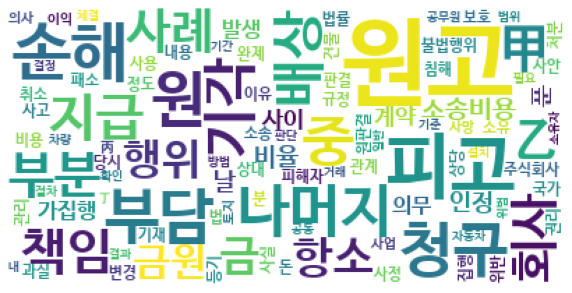

In [213]:
# wordcloud 패키지 다운로드
!pip install wordcloud
from wordcloud import WordCloud
wc = WordCloud(background_color="white", font_path='/Users/byeonghyeon/Documents/GitHub/IndustrialSystemsEngineering_Project/font/NanumBarunGothicBold.ttf')
wc.generate_from_frequencies(top_nouns)
# World
# 많이 나타나는 단어일수록 크게 나타남
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)

In [214]:
from konlpy.tag import Okt
okt = Okt()

oo = okt.pos(posts[0],
        norm=True,   # 정규화(normalization)
        stem=True    # 어간추출(stemming)
        )

print(oo)

[('甲', 'Foreign'), ('이', 'Noun'), ('배우자', 'Noun'), ('乙', 'Foreign'), ('의', 'Noun'), ('성', 'Modifier'), ('기능', 'Noun'), ('장애', 'Noun'), ('로', 'Josa'), ('인하다', 'Adjective'), ('사실혼', 'Noun'), ('관계', 'Noun'), ('가', 'Josa'), ('단기간', 'Noun'), ('에', 'Josa'), ('파탄', 'Noun'), ('되어다', 'Verb'), ('이유', 'Noun'), ('로', 'Josa'), ('乙', 'Foreign'), ('을', 'Josa'), ('상대로', 'Noun'), ('손해배상', 'Noun'), ('등', 'Noun'), ('을', 'Josa'), ('구한', 'Noun'), ('사안', 'Noun'), ('에서', 'Josa'), (',', 'Punctuation'), ('乙', 'Foreign'), ('은', 'Noun'), ('甲', 'Foreign'), ('에게', 'Josa'), ('위자료', 'Noun'), ('지급', 'Noun'), ('의무', 'Noun'), ('가', 'Josa'), ('있다', 'Adjective'), (',', 'Punctuation'), ('원상회복', 'Noun'), ('으로서', 'Josa'), ('甲', 'Foreign'), ('에게', 'Josa'), ('받다', 'Verb'), ('예물', 'Noun'), ('과', 'Josa'), ('점유', 'Noun'), ('중인', 'Noun'), ('혼수', 'Noun'), ('품', 'Noun'), ('등', 'Noun'), ('을', 'Josa'), ('인도', 'Noun'), ('하다', 'Verb'), ('의무', 'Noun'), ('가', 'Josa'), ('있다', 'Adjective'), ('하다', 'Verb'), ('사례', 'Noun'), ('甲', 'Foreign'),

In [215]:
# 첫번째 tokenizer(Okt)
def tokenizer_1(raw_texts, pos=["Noun","Alpha","Verb","Number"], stop_words=list(stop_words_df.get("불용어"))):
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word[0] not in stop_words]
    return(o)

print(posts[5])
print(tokenizer_1(posts[5]))

하천부지 시효취득의 가부 하천부지는 그 공용성이 폐지된 이후가 아니면 취득시효의 목적이 될 수 없다.  원판결을 취소한다. 피고는 원고에 대하여 김제군 죽산면 죽산리 708번지의 23 경작지(하천부지) 답 3,070평을 인도하고 금 28만환을 지불하라. 원고 이여의 청구를 기각한다. 소송비용은 제1,2심 공히 피고의 부담으로 한다.
['부지', '시효', '취득', '부지', '공용', '폐지', '되다', '취득시효', '목적', '되다', '판결', '취소', '피고', '원고', '대하', '김제군', '죽산면', '죽산', '708', '번지', '23', '경작지', '부지', '3,070', '인도', '28만', '지불', '원고', '청구', '기각', '소송비용', '피고', '부담']


In [216]:
# 첫번째 tokenizer(Okt)
def tokenizer_3(raw_texts, pos=["Noun"], stop_words=list(stop_words_df.get("불용어"))):
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word[0] not in stop_words]
    return(o)

print(posts[5])
print(tokenizer_3(posts[5]))

하천부지 시효취득의 가부 하천부지는 그 공용성이 폐지된 이후가 아니면 취득시효의 목적이 될 수 없다.  원판결을 취소한다. 피고는 원고에 대하여 김제군 죽산면 죽산리 708번지의 23 경작지(하천부지) 답 3,070평을 인도하고 금 28만환을 지불하라. 원고 이여의 청구를 기각한다. 소송비용은 제1,2심 공히 피고의 부담으로 한다.
['부지', '시효', '취득', '부지', '공용', '폐지', '취득시효', '목적', '판결', '취소', '피고', '원고', '대하', '김제군', '죽산면', '죽산', '번지', '경작지', '부지', '인도', '지불', '원고', '청구', '기각', '소송비용', '피고', '부담']


In [217]:
# 두번째 tokenizer(mecab)
def tokenizer_2(raw_texts, pos=["Noun","Alpha","Verb","Number"], stop_words=list(stop_words_df.get("불용어"))):
    nouns = []
  
    for noun in tagger.nouns(raw_texts):
        if noun not in stop_words and len(noun)>1:
            nouns.append(noun)
    return nouns
print(posts[5])
print(tokenizer_2(posts[5]))

하천부지 시효취득의 가부 하천부지는 그 공용성이 폐지된 이후가 아니면 취득시효의 목적이 될 수 없다.  원판결을 취소한다. 피고는 원고에 대하여 김제군 죽산면 죽산리 708번지의 23 경작지(하천부지) 답 3,070평을 인도하고 금 28만환을 지불하라. 원고 이여의 청구를 기각한다. 소송비용은 제1,2심 공히 피고의 부담으로 한다.
['하천', '부지', '시효', '취득', '가부', '부지', '공용', '폐지', '이후', '취득시효', '목적', '원판결', '취소', '원고', '김제군', '죽산면', '죽산리', '번지', '경작지', '하천', '부지', '인도', '만환', '지불', '원고', '이여', '청구', '기각', '소송비용', '피고', '부담']


In [218]:
vectorize = TfidfVectorizer(
    tokenizer = tokenizer_1, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df = 10,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf = True,    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
    stop_words = list(stop_words_df.get("불용어"))
)

X = vectorize.fit_transform(posts)
pd.DataFrame(X.toarray())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['결과', '고려', '공동', '관계', '근거', '기대', '기점', '기준', '낫다', '다시', '대로', '대하', '더불다', '도착', '동시', '두번째', '뒤따르다', '따다', '따르다', '따름', '라면', '리하', '마자', '막론', '만이', '만큼', '만하', '말다', '망정', '몰랏다', '무릎', '반대', '방면', '보다', '보아', '본대', '부류', '불구', '불문', '비걱거리', '비교', '비기다', '비추다', '상대', '생각', '서술', '시오', '시작', '시초', '쓰다', '쓰이다', '안다', '않다', '알다', '연관', '울다', '입다', '입장', '잇따르다', '정도', '종합', '주저', '즈음', '지경', '지다', '진짜', '차다', '켜다', '크다', '틈타다', '편이', '한적', '해도', '해보다', '형식'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,0,1,2,3,4,5,6,7,8,9,...,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359
0,0.0,0.0,0.0,0.146969,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.173097,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.265008,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.191874,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1824,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.060788,0.0,0.0
1825,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1826,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.097623,0.0,0.0


In [219]:
# pd.DataFrame(X.toarray()).to_excel("TF-IDF_Vectors.xlsx",index=False)

In [57]:
# vectorize = CountVectorizer(
# #     tokenizer=tokenizer, 
#     min_df=5    # 예제로 보기 좋게 1번 정도만 노출되는 단어들은 무시하기로 했다
#                 # min_df = 0.01 : 문서의 1% 미만으로 나타나는 단어 무시
#                 # min_df = 10 : 문서에 10개 미만으로 나타나는 단어 무시
#                 # max_df = 0.80 : 문서의 80% 이상에 나타나는 단어 무시
#                 # max_df = 10 : 10개 이상의 문서에 나타나는 단어 무시
# )
# X = vectorize.fit_transform(posts)
# # print('fit_transform, (sentence {}, feature {})'.format(X.shape[0], X.shape[1]))

# # 문장에서 뽑아낸 feature 들의 배열
# features = vectorize.get_feature_names()

# X.toarray()
# tf_idf_df = pd.DataFrame(X.toarray())
# tf_idf_df

,0,1,2,3,4,5,6,7,8,9,...,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [220]:
tfidf_df = pd.DataFrame(X.toarray())
# tfidf_df = pd.read_excel("TF-IDF_vectors.xlsx")
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
# 2번째와 3번째 문서(유클리디안 거리 값)
print(euclidean_distances(X[1], X[2]))#, X)
# 2번째와 3번째 문서(코사인유사도 값)
print(cosine_similarity(X[1], X[0]))#, X)
# [[0.1837195]]

[[1.3765287]]
[[0.13788812]]


In [232]:
# target_id 와 유사한 판례를 cosine_similarity으로 계산하여 유사벡터 도출
# 약 1분 소요
cosine_result = {}
error_reslut = {}
target_id = 165171
x = info_df[info_df['ID']==target_id].index[0]  # target_id의 Id값의 index

for y in range(len(info_df)):
    try:
        cosine_result[info_df['ID'].iloc[y]] = cosine_similarity(X[x], X[y])[0][0]
#         print(x,y,cosine_similarity(X[x], X[y]))
    except:
        error_reslut[info_df["ID"].iloc[y]] = cosine_similarity(X[x], X[y])
        print("error",x,y,cosine_similarity(X[x], X[y]))
sorted_cosine_dic = sorted(cosine_result.items(), key = lambda x:x[1], reverse = True)

# cosine_similariry 값 기준으로 내림차순 정렬된 유사 판례들
# 먼저나올수록 유사한 판례이다.
sorted_cosine_dic[0:11]

[(165171, 1.0000000000000002),
 (73467, 0.2957832648322016),
 (76344, 0.28919640363942906),
 (120531, 0.27461428277820593),
 (73705, 0.25894215524973396),
 (119997, 0.2440769984239502),
 (74980, 0.2419386521551339),
 (210289, 0.2334660147238246),
 (190181, 0.23091743616380242),
 (176463, 0.22142992692076685),
 (120705, 0.2199886403917139)]

In [233]:
id_list = [i[0] for i in sorted_cosine_dic[0:11]]
for i in sorted_cosine_dic[0:11]:
    print(info_df[info_df["ID"]==i[0]]["참조조문"].iloc[0])

민법 제806조
민법 제760조
, 
        제425조
의료법 제37조
민법 제800조
, 
        제806조
, 
        제812조
민법 제763조
, 
        제393조
민법 제840조
, 
        제843조
, 
        제806조
민법 제750조, 
        가정의례에관한법률 제3조, 
        제4조
[1] 민법 제105조, 제539조/ [2] 민법 제454조, 제539조/ [3] 민법 제539조, 제542조/ [4] 민법 제539조, 제548조, 제741조
민법 제103조, 
        제812조 제1항
민법 제751조, 제812조
민법 제750조


In [234]:
cnt_기각 = 0
cnt_승소 = 0
cnt_일부승소 = 0
id_list = [i[0] for i in sorted_cosine_dic[1:11]]
for i in sorted_cosine_dic[1:11]:
    print(info_df[info_df["ID"]==i[0]]["주문"].iloc[0])
    if '나머지 청구를 기각한다' in info_df[info_df["ID"]==i[0]]["주문"].iloc[0] or "나머지 항소를 기각한다" in info_df[info_df["ID"]==i[0]]["주문"].iloc[0]:
        print("결과 : 일부승소")
        cnt_일부승소 += 1
    elif "기각" in info_df[info_df["ID"]==i[0]]["주문"].iloc[0]:
        print("결과 : 기각")
        cnt_기각 += 1
    else:
        print("결과 : 승소")
        cnt_승소 += 1
    print()

print("기각 :{}건\n승소 : {}건\n일부 승소 {}건".format(cnt_기각,cnt_승소,cnt_일부승소)) 


 원판결을 다음과 같이 변경한다. 피고(반소원고)는 원고(반소피고) 김춘자에게 금 364,387원, 원고(반소피고) 유희경에게 금 164,387원 및 각 이에 대한 1972.2.28.부터 완제에 이르기까지 연 5푼의 비율에 의한 금원을 지급하라. 원고등(반소피고등)은 피고(반소원고)에게 각 금 498,533원을지급하라. 원고등(반소피고등)의 나머지청구와 항소 및 피고(반소원고)의 나머지청구를 모두 기각한다. 소송비용은 본소 및 반소를 통하여 제1,2심 모두 이를 5분하여 그 2를 피고(반소원고), 그나머지를 원고등(반소피고등)의 각 부담으로 한다.
결과 : 기각

 피고(반소원고)는 원고(반소피고) 1, 원고 2에게 각 금 5,284,897원, 원고 3, 4, 5에게 각 금 200,000원 및 이 돈들에 대한 1982.7.12.부터 완제일까지 연 5푼의 비율에 의한 돈을 지급하라. 원고들의 나머지 청구 및 피고(반소원고)의 반소청구를 모두 기각한다. 소송비용중 본소로 인한 부분은 이를 10등분하여 그 6은 피고(반소원고)의 나머지는 원고들의 각 부담으로 하고 반소로 인한 부분은 피고(반소원고)의 각 부담으로 한다. 위 제1항중 2/3는 가집행할 수 있다.
결과 : 기각

  1.  원고의 청구를 모두 기각한다.  2.  소송비용은 원고의 부담으로 한다.
결과 : 기각

 원판결을 다음과 같이 변경한다. 피고(반소원고)는 원고(반소피고)에게 금 7,355,838원 및 이에대한 1974.3.16.부터 완제일까지 연 5푼의 율에 의한 금원을 지급하고, 원고(반소피고)는 피고(반소원고)에게 금 1,178,400원 및 이에대한 1973.12.21.부터 완제일까지 연 5푼의 율에 의한 금원을 지급하라. 원고(반소피고) 및 피고(반소원고)의 나머지청구와 반소에 관한 피고(반소원고)의 항소를 모두 기각한다. 소송비용은 1,2심 모두 본소, 반소를 통하여 이를 3분하여 그 1은 원고(반소피고)의, 나머지는 피고(반소원고)의 각 부담으로 한다. 위 제2항은 원심인용의 금원을 초

In [235]:
# target_id 에 해당하는 판례와 유사한 판례 상위 10개 도출
for id_ in sorted_cosine_dic[0:11]:
    url = "http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID={}&type=XML".format(id_[0])
    url2 = "https://www.law.go.kr/precInfoP.do?mode=0&precSeq={}&vSct=*".format(id_[0])
    print(url2)

https://www.law.go.kr/precInfoP.do?mode=0&precSeq=165171&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=73467&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=76344&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=120531&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=73705&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=119997&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=74980&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=210289&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=190181&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=176463&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=120705&vSct=*


# TF-IDF Vectorizer (tokenizer_2)

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize = TfidfVectorizer(
    tokenizer = tokenizer_2, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df = 10,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf = True,    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
    stop_words = list(stop_words_df.get("불용어"))
)

X2 = vectorize.fit_transform(posts)
pd.DataFrame(X2.toarray())

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['개의', '거니', '결과', '고려', '고용', '공동', '관계', '구체', '구토', '근거', '기관', '기점', '기준', '나다', '나머지', '노동', '노동부', '대로', '도착', '동시', '따름', '때문', '마음', '방면', '부령', '부류', '불문', '비교', '사람', '상대', '생각', '서술', '시작', '시초', '아래', '아무', '연관', '의거', '의지', '이외', '이용', '이유', '일반', '일지', '입각', '입장', '정도', '제외', '종합', '주저', '즈음', '지경', '진짜', '필요', '한적', '할만', '항목', '행정', '형식'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,0,1,2,3,4,5,6,7,8,9,...,681,682,683,684,685,686,687,688,689,690
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.292341,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [59]:
tfidf2_df = pd.DataFrame(X2.toarray())
# tfidf_df = pd.read_excel("TF-IDF_vectors.xlsx")

In [61]:
# target_id 와 유사한 판례를 cosine_similarity으로 계산하여 유사벡터 도출
# 약 1분 소요
cosine_result = {}
error_reslut = {}
target_id = 208911
x = info_df[info_df['ID']==target_id].index[0]  # target_id의 Id값의 index

for y in range(len(info_df)):
    try:
        cosine_result[info_df['ID'].iloc[y]] = cosine_similarity(X2[x], X2[y])[0][0]
#         print(x,y,cosine_similarity(X[x], X[y]))
    except:
        error_reslut[info_df["ID"].iloc[y]] = cosine_similarity(X2[x], X2[y])
        print("error",x,y,cosine_similarity(X2[x], X2[y]))
sorted_cosine_dic = sorted(cosine_result.items(), key = lambda x:x[1], reverse = True)

# cosine_similariry 값 기준으로 내림차순 정렬된 유사 판례들
# 먼저나올수록 유사한 판례이다.
sorted_cosine_dic 

[(120133, 1.0000000000000002),
 (129739, 0.37256836400600385),
 (120464, 0.37256836400600385),
 (212507, 0.328236921610331),
 (70246, 0.28117119015268655),
 (209921, 0.2762261260762003),
 (71996, 0.2638279577634479),
 (118606, 0.2423036204095516),
 (72187, 0.22113891122101273),
 (73774, 0.2197174694847632),
 (119878, 0.2151113561421116),
 (72819, 0.21350012995654516),
 (75417, 0.21092495458558447),
 (70203, 0.21043006718472232),
 (118426, 0.206269842966958),
 (75136, 0.2059731191005069),
 (76169, 0.20447559543832305),
 (73692, 0.20343987762727006),
 (118534, 0.1937332116490188),
 (76739, 0.1936318173887942),
 (73500, 0.19285311189254709),
 (69839, 0.1922181287348894),
 (72149, 0.18178746394506204),
 (71387, 0.18061386390133538),
 (140825, 0.17870098850907876),
 (71623, 0.1780455777370669),
 (73467, 0.17562091869861585),
 (145789, 0.17339294456089746),
 (76600, 0.1729371467207863),
 (73740, 0.17276805698193465),
 (212161, 0.17059039562602757),
 (212347, 0.16877331641815263),
 (118944, 0

In [62]:
# target_id 에 해당하는 판례와 유사한 판례 상위 10개 도출
for id_ in sorted_cosine_dic[0:11]:
    url = "http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID={}&type=XML".format(id_[0])
    url2 = "https://www.law.go.kr/precInfoP.do?mode=0&precSeq={}&vSct=*".format(id_[0])
    print(url)

http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=120133&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=129739&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=120464&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=212507&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=70246&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=209921&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=71996&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=118606&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=72187&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=73774&type=XML
http://www.law.go.kr/DRF/lawService.do?OC=iambyunghyun&target=prec&ID=119878&type=XML


# DBSCAN Clustering

1.3037172990980979


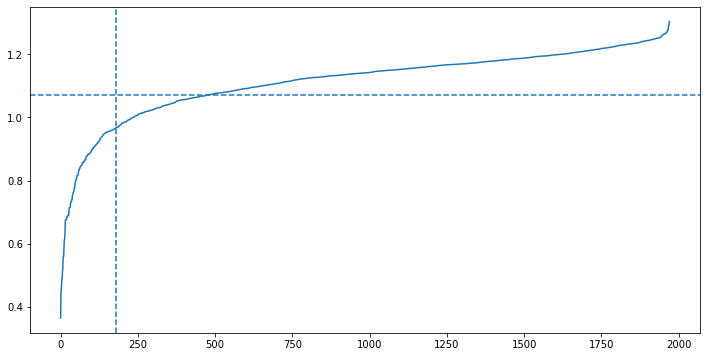

In [65]:
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X2)
distances, indices = neigh.kneighbors(X2)
plt.figure(figsize=(12, 6))
plt.plot(np.sort(distances[:, 4]))
plt.axvline(178, 0, 2, ls='--')
plt.axhline(1.07, 0, 200, ls='--')
print(np.sort(distances[:, 4])[1970])

In [83]:
# dbscan = DBSCAN(eps = 0.5, min_samples=5)
ss = StandardScaler()
scaled_df = pd.DataFrame(ss.fit_transform(tfidf_df))
dbscan = DBSCAN(eps = 0.1)
dbscan_cluster = dbscan.fit_predict(scaled_df)
dbscan_cluster

array([-1, -1, -1, ..., -1, -1, -1])

In [84]:
# 군집화 된 패키지들을 DataFrame에 잘 들어가도록 전처리

dbscan_clustered_dic = {}
dbscan_clustered_list = []
dbscan_cluster_num = len(set(dbscan_cluster))
for idx,i in enumerate(dbscan_cluster):
    if i not in dbscan_clustered_dic:
        dbscan_clustered_dic[i] = [info_df['ID'].iloc[idx]]
    else:
        dbscan_clustered_dic[i].append(info_df['ID'].iloc[idx])
dbscan_clustered_dic
# 클러스터링이 된 패키지들
# 20개의 군집으로 생성

dbscan_clustered_dic = sorted(dbscan_clustered_dic.items(), key=lambda x: x[0])
dbscan_clustered_dic

[(-1,
  [165171,
   167374,
   74874,
   74855,
   75007,
   71848,
   71846,
   120823,
   120176,
   133481,
   71164,
   192385,
   118780,
   70572,
   118303,
   69820,
   119193,
   118253,
   118538,
   119274,
   119294,
   119276,
   118460,
   184658,
   65017,
   118611,
   118444,
   118853,
   118686,
   69915,
   71871,
   212425,
   208477,
   159788,
   138226,
   76752,
   140320,
   69740,
   69676,
   205652,
   177819,
   72156,
   146042,
   77021,
   76919,
   76837,
   76831,
   76760,
   76756,
   146045,
   77025,
   77024,
   76834,
   76833,
   76827,
   76826,
   76822,
   146013,
   76879,
   76859,
   76778,
   76678,
   118851,
   146034,
   76954,
   73539,
   75804,
   120531,
   214537,
   74659,
   176571,
   176463,
   190229,
   142045,
   69745,
   69689,
   72644,
   72154,
   71449,
   138188,
   129754,
   76131,
   75945,
   75940,
   75834,
   75609,
   75601,
   75571,
   75560,
   75535,
   75531,
   75522,
   75411,
   75410,
   75398,
   7

In [85]:
df_dbscan_cluster = pd.DataFrame(dbscan_clustered_dic,columns=['num','clusters'])
dbscan_cluster_num = [len(i) for i in df_dbscan_cluster['clusters']]
df_dbscan_cluster['cluster_num'] = dbscan_cluster_num
df_dbscan_cluster

,num,clusters,cluster_num
0,-1,"[165171, 167374, 74874, 74855, 75007, 71848, 7...",1971


# Kmeans

In [95]:
# Instantiate the clustering model 
# n_init : 랜덤한 초기값을 몇번이나 다르게 설정해서 돌릴건지
# max_iter=300 : iteration을 반복적으로 수행하면 서 좋을 결과로 수렴하게되는데 그 횟수를 몇번 할 것인지
# verbose : 계산과정 보여줌 0,1,2 이렇게 해서 보여주는 정보의 양을 조절 할 수있음

# 15개의 클러스터를 만들기 
n_clusters = 18
kmeans = KMeans(n_clusters=n_clusters)
# kmeans = KMeans(n_clusters=4,verbose = 1)
kmeans

KMeans(n_clusters=18)

In [96]:
# 모델에 fitting 하기
kmeans.fit(scaled_df)

y_kmeans = kmeans.predict(scaled_df)
y_kmeans[0:10] # 군집화 된 결과


array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12], dtype=int32)

In [97]:
# 군집의 중심
kmeans.cluster_centers_

array([[-0.10355281, -0.04797661, -0.04808464, ..., -0.19100177,
        -0.06979473, -0.1037531 ],
       [-0.10355281, -0.04797661, -0.04808464, ...,  0.07389277,
        -0.06979473, -0.1037531 ],
       [-0.10355281, -0.04797661, -0.04808464, ..., -0.19100177,
        -0.06979473, -0.1037531 ],
       ...,
       [ 0.29584673, -0.04797661, -0.04808464, ..., -0.19100177,
        -0.06979473, -0.1037531 ],
       [-0.10355281, -0.04797661, -0.04808464, ..., -0.19100177,
        -0.06979473, -0.1037531 ],
       [-0.10355281, -0.04797661, -0.04808464, ..., -0.19100177,
        -0.06979473, -0.1037531 ]])

In [98]:
kmeans.labels_[0:8]

array([12, 12, 12, 12, 12, 12, 12, 12], dtype=int32)

In [99]:
# 클러스터링의 성능측정
# 값이 높을 수록 좋음
kmeans.inertia_

2575144.229369248

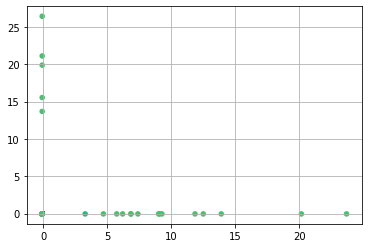

In [139]:
plt.scatter(np.array(scaled_df)[:,3], np.array(scaled_df)[:,4], c=y_kmeans, s=20, cmap='viridis')

centers = kmeans.cluster_centers_
# plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.5)
plt.grid()
plt.show()

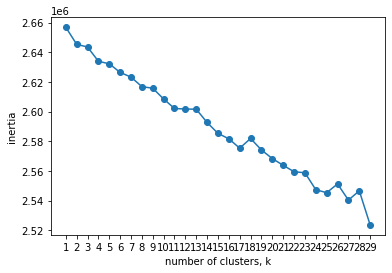

In [100]:
ks = range(1,30)

inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(scaled_df)
    inertias.append(model.inertia_)
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [102]:
# 군집화 된 패키지들을 DataFrame에 잘 들어가도록 전처리

clustered_dic = {}
clustered_list = []
cluster_num = len(set(y_kmeans))
for idx,i in enumerate(y_kmeans):
    if i not in clustered_dic:
        clustered_dic[i] = [info_df['ID'].iloc[idx]]
    else:
        clustered_dic[i].append(info_df['ID'].iloc[idx])
clustered_dic
# 클러스터링이 된 패키지들
# 20개의 군집으로 생성

clustered_dic = sorted(clustered_dic.items(), key=lambda x: x[0])
clustered_dic

[(0, [168172]),
 (1,
  [75522,
   75410,
   76037,
   75417,
   74104,
   73544,
   72175,
   76497,
   76045,
   72954,
   77018,
   119192,
   119283,
   119112]),
 (2, [75935, 75727, 73958, 174783]),
 (3, [74877, 74524, 72837, 139105, 118435]),
 (4, [146013, 72602, 73511, 212171, 70733, 70083, 210003, 70246]),
 (5, [138188, 143475, 168211, 138584, 149312, 139109]),
 (6,
  [75190,
   118618,
   129660,
   125073,
   70277,
   71382,
   119029,
   70505,
   136181,
   71383,
   71459,
   190212,
   190207]),
 (7, [72807, 72227, 209921, 145894, 129739, 120464, 69845]),
 (8, [77021, 75207, 73020, 75625, 70681, 119445, 138583, 70245]),
 (9,
  [75577,
   76251,
   76170,
   70565,
   185121,
   183092,
   157331,
   119619,
   118542,
   160216,
   118609,
   129757,
   119623,
   69821,
   120719,
   183581,
   147265,
   71053,
   121014,
   212321,
   118683,
   118260]),
 (10, [70770, 139803, 70683, 70394, 192840, 179473]),
 (11,
  [69676,
   177819,
   75947,
   74250,
   76128,
   7

In [103]:
df_cluster = pd.DataFrame(clustered_dic,columns=['num','clusters'])
cluster_num = [len(i) for i in df_cluster['clusters']]
df_cluster['cluster_num'] = cluster_num
df_cluster

,num,clusters,cluster_num
0,0,[168172],1
1,1,"[75522, 75410, 76037, 75417, 74104, 73544, 721...",14
2,2,"[75935, 75727, 73958, 174783]",4
3,3,"[74877, 74524, 72837, 139105, 118435]",5
4,4,"[146013, 72602, 73511, 212171, 70733, 70083, 2...",8
5,5,"[138188, 143475, 168211, 138584, 149312, 139109]",6
6,6,"[75190, 118618, 129660, 125073, 70277, 71382, ...",13
7,7,"[72807, 72227, 209921, 145894, 129739, 120464,...",7
8,8,"[77021, 75207, 73020, 75625, 70681, 119445, 13...",8
9,9,"[75577, 76251, 76170, 70565, 185121, 183092, 1...",22


# T-SNE

In [68]:
m = TSNE(learning_rate = 50)
tsne_features = m.fit_transform(pd.DataFrame(X.toarray()))
tsne_features

array([[ 11.713136 ,  -0.6022211],
       [  5.7689567, -26.842829 ],
       [  1.9470499,   5.0987253],
       ...,
       [-14.455205 ,   5.421204 ],
       [  7.228041 ,  -6.4370637],
       [  0.9948009, -26.625072 ]], dtype=float32)

In [69]:
df = pd.DataFrame()
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]

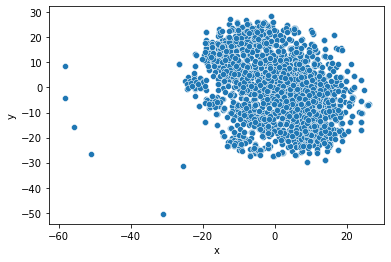

In [72]:
sns.scatterplot(x="x",y="y",data = df)
plt.show()

In [77]:
tsne_features

array([[ 11.713136 ,  -0.6022211],
       [  5.7689567, -26.842829 ],
       [  1.9470499,   5.0987253],
       ...,
       [-14.455205 ,   5.421204 ],
       [  7.228041 ,  -6.4370637],
       [  0.9948009, -26.625072 ]], dtype=float32)

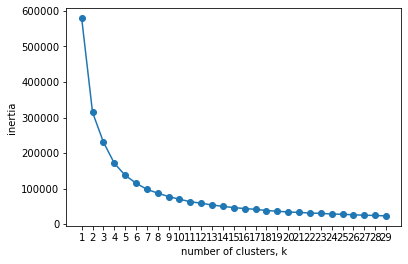

In [83]:
ks = range(1,30)

inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(tsne_features)
    inertias.append(model.inertia_)
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [84]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters)
# kmeans = KMeans(n_clusters=4,verbose = 1)
kmeans

# 모델에 fitting 하기
kmeans.fit(tsne_features)

y_kmeans = kmeans.predict(tsne_features)
y_kmeans[0:10] # 군집화 된 결과


array([4, 0, 7, 7, 1, 7, 3, 2, 3, 4], dtype=int32)

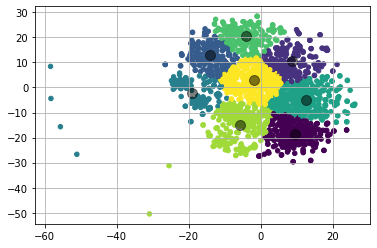

In [85]:
plt.scatter(np.array(tsne_features)[:,0], np.array(tsne_features)[:,1], c=y_kmeans, s=20, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.5)
plt.grid()
plt.show()

In [86]:
# 군집화 된 패키지들을 DataFrame에 잘 들어가도록 전처리

clustered_dic = {}
clustered_list = []
cluster_num = len(set(y_kmeans))
for idx,i in enumerate(y_kmeans):
    if i not in clustered_dic:
        clustered_dic[i] = [info_df['ID'].iloc[idx]]
    else:
        clustered_dic[i].append(info_df['ID'].iloc[idx])
clustered_dic
# 클러스터링이 된 패키지들
# 20개의 군집으로 생성

clustered_dic = sorted(clustered_dic.items(), key=lambda x: x[0])
clustered_dic

[(0,
  [167374,
   192385,
   70572,
   118303,
   118538,
   118444,
   76837,
   76834,
   76833,
   72154,
   75107,
   73509,
   72666,
   76739,
   75429,
   75201,
   74919,
   74905,
   74883,
   74843,
   75005,
   73934,
   73799,
   73247,
   152040,
   72787,
   72757,
   72518,
   72239,
   72085,
   72052,
   152078,
   76742,
   76396,
   75426,
   75388,
   75145,
   74484,
   74286,
   74061,
   73758,
   73723,
   73531,
   73513,
   73439,
   73253,
   73206,
   73067,
   72812,
   72753,
   152055,
   72390,
   72231,
   72107,
   76147,
   75631,
   75625,
   72945,
   72147,
   118962,
   70563,
   129677,
   210941,
   206200,
   164922,
   69891,
   140824,
   138184,
   136180,
   212127,
   119443,
   71525,
   120048,
   119875,
   140844,
   164800,
   70423,
   120250,
   71355,
   161854,
   138569,
   71358,
   70630,
   69535,
   120834,
   120829,
   129750,
   119873,
   69957,
   210289,
   71113,
   120630,
   190761,
   143475,
   71090,
   70350,
  

In [161]:
df_cluster = pd.DataFrame(clustered_dic,columns=['num','clusters'])
cluster_num = [len(i) for i in df_cluster['clusters']]
df_cluster['cluster_num'] = cluster_num
df_cluster

,num,clusters,cluster_num
0,0,"[167374, 192385, 70572, 118303, 118538, 118444...",256
1,1,"[75007, 118780, 119294, 76879, 76678, 76954, 7...",225
2,2,"[120823, 138226, 76752, 69676, 75804, 190229, ...",195
3,3,"[71846, 120176, 118611, 146042, 77021, 76831, ...",143
4,4,"[165171, 133481, 119276, 118460, 118853, 21242...",309
5,5,"[118253, 65017, 69915, 71871, 76756, 77025, 76...",190
6,6,"[119193, 184658, 118686, 208477, 69740, 205652...",264
7,7,"[74874, 74855, 71848, 71164, 69820, 119274, 76...",389


In [162]:
nouns_entire = []
for i in df_cluster["clusters"]:
    nouns_temp = []
    for j in i:
        for noun in tagger.nouns(info_df[info_df["ID"] == j]["판시사항"].iloc[0]):
            if noun not in list(stop_words_df.get("불용어")):
                nouns_temp.append(noun) 
    nouns_entire.append(nouns_temp)

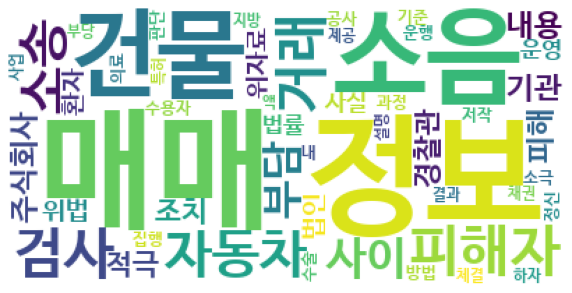

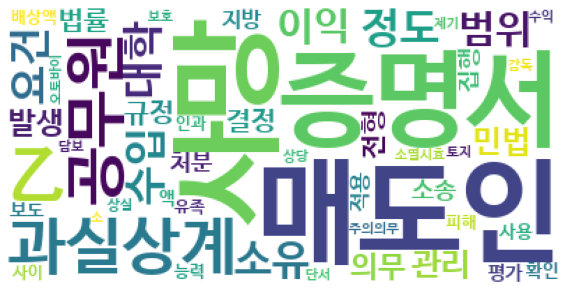

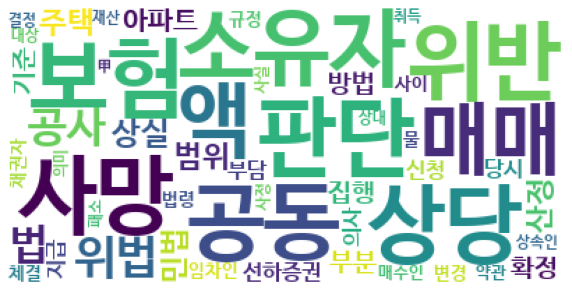

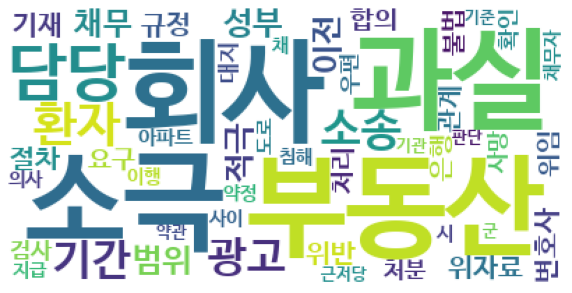

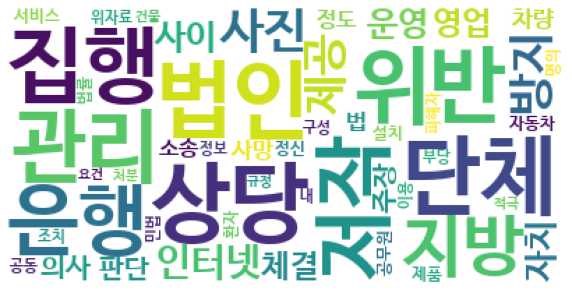

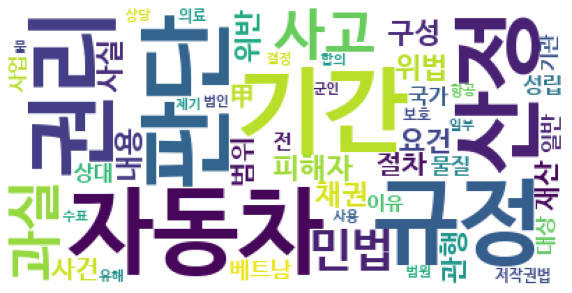

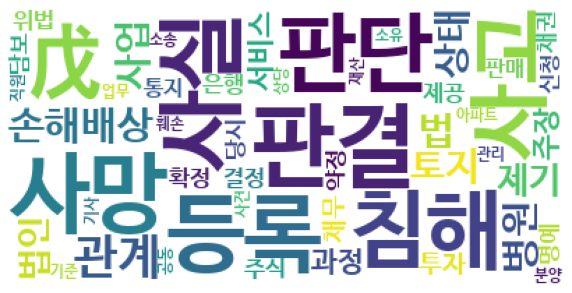

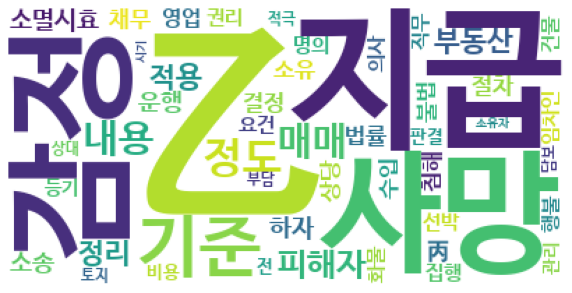

In [167]:
for idx,nouns in enumerate(nouns_entire):
    num_top_nouns = 82
    nouns_counter = Counter(nouns)
    top_nouns = dict(nouns_counter.most_common(num_top_nouns)[32:])
#     print(top_nouns)
    wc = WordCloud(background_color="white", font_path='/Users/byeonghyeon/Documents/GitHub/IndustrialSystemsEngineering_Project/font/NanumBarunGothicBold.ttf')
    wc.generate_from_frequencies(top_nouns)
    # World
    # 많이 나타나는 단어일수록 크게 나타남
    figure = plt.figure()
    figure.set_size_inches(10, 10)
    ax = figure.add_subplot(1, 1, 1)
    ax.axis("off")
    ax.imshow(wc)
    plt.savefig('{}cluster.png'.format(idx+1))


In [139]:
df_cluster.to_excel("K-Means_clusters.xlsx",index=False)

In [159]:
for i in df_cluster.iloc[2]["clusters"]:
    url2 = "https://www.law.go.kr/precInfoP.do?mode=0&precSeq={}&vSct=*".format(i)
    print(url2)

https://www.law.go.kr/precInfoP.do?mode=0&precSeq=120823&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=138226&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=76752&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=69676&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=75804&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=190229&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=129754&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=74516&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=76574&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=76048&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=75935&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=75121&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=74896&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=74978&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=74960&vSct=*
https://www.law.go.kr/precInfoP.do?mode=0&precSeq=7